# Pump It Up Challenge - Cleaning

The approach for this was adapted from Desislava Petkova, who performed the analysis in R. That repository can be viewed [here](https://github.com/dipetkov/DrivenData-PumpItUp/blob/master/transform-data.md).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime as dt
from scripts import pumpitup

from scipy import stats

from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold

sns.set_style("white")
sns.set_context("talk")

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_columns = 50

# Training Data

## Data

In [4]:
train_data = pd.read_csv('data/training_set.csv')

In [5]:
backup = pd.read_csv('data/training_set.csv')

In [6]:
train_data.shape
train_data.head(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


First, it's interesting to see how many unique values there are for every feature, which gives us an insight into the granularity and usefulness of each one.

We can see that there are some similarly named features which might also share similar levels of detail, while some of them contain thousands of possible values.

In [7]:
df_uniques = pumpitup.unique_count(train_data)
df_uniques

,Feature,Uniques
0,id,59400
1,amount_tsh,98
2,date_recorded,356
3,funder,1898
4,gps_height,2428
5,installer,2146
6,longitude,57516
7,latitude,57517
8,wpt_name,37400
9,num_private,65


Next we can look at the percentage of missing values for each feautre. My function treats zeros as missing values for numeric data, but we should bear the context in mind when interpreting this.

One interesting example is `num_private` where we previously saw that there were 65 values that it could take, but we now see that almost 99% of them are 0, probably rendering the feature useless to us. We also have a few other features with large proportions of missing data, which we address later.

In [8]:
pumpitup.percent_missing(train_data)

id 0.001684 0
amount_tsh 70.099327 0
funder 6.119529 NaN
gps_height 34.407407 0
installer 6.153199 NaN
longitude 3.050505 0
latitude 3.050505 0
wpt_name 5.998316 none
num_private 98.725589 0
subvillage 0.624579 NaN
region_code 0.000000 0
district_code 0.038721 0
population 35.994949 0
public_meeting 5.612795 NaN
scheme_management 6.526936 NaN
scheme_name 47.417508 NaN
permit 5.144781 NaN
construction_year 34.863636 0


[]

## Labels

In [9]:
train_labels = pd.read_csv('data/training_labels.csv')

In [10]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [11]:
train_labels['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

## Cleaning

We can immediately remove the `id` feature as it is unique for each row and therefore will not help our preduction. Conversely the `recorded_by` takes a single value for the whole dataset, so this can also be removed.

In [12]:
train_data.drop(['id', 'recorded_by', 'num_private'], axis=1, inplace=True)

### Extraction Types

Looking at `extraction_type_class`, `extraction_type_group` and `extraction_type`, we can see a hierarchy of classification, with `extract_type` as the most granular and `extraction_type_class` the most coarse.

We remove the mid level information and refactor the finest feature.

There are no missing values to take care of.

In [13]:
extraction_types = train_data.groupby(['extraction_type_class', 'extraction_type_group', 'extraction_type'])
extraction_types.count()

amount_tsh  \
extraction_type_class extraction_type_group extraction_type                         
gravity               gravity               gravity                         26780   
handpump              afridev               afridev                          1770   
                      india mark ii         india mark ii                    2400   
                      india mark iii        india mark iii                     98   
                      nira/tanira           nira/tanira                      8154   
                      other handpump        other - mkulima/shinyanga           2   
                                            other - play pump                  85   
                                            other - swn 81                    229   
                                            walimi                             48   
                      swn 80                swn 80                           3670   
motorpump             mono                  mono                             2865   
                      other motorpump       cemo                               90   
                                            climax                             32   
other                 other                 other                            6430   
rope pump             rope pump             other - rope pump                 451   
submersible           submersible           ksb                              1415   
                                            submersible                      4764   
wind-powered          wind-powered          windmill                          117   

                                                                       date_recorded  \
extraction_type_class extraction_type_group extraction_type                            
gravity               gravity               gravity                            26780   
handpump              afridev               afridev                             1770   
                      india mark ii         india mark ii                       2400   
                      india mark iii        india mark iii                        98   
                      nira/tanira           nira/tanira                         8154   
                      other handpump        other - mkulima/shinyanga              2   
                                            other - play pump                     85   
                                            other - swn 81                       229   
                                            walimi                                48   
                      swn 80                swn 80                              3670   
motorpump             mono                  mono                                2865   
                      other motorpump       cemo                                  90   
                                            climax                                32   
other                 other                 other                               6430   
rope pump             rope pump             other - rope pump                    451   
submersible           submersible           ksb                                 1415   
                                            submersible                         4764   
wind-powered          wind-powered          windmill                             117   

                                                                       funder  \
extraction_type_class extraction_type_group extraction_type                     
gravity               gravity               gravity                     24704   
handpump              afridev               afridev                      1668   
                      india mark ii         india mark ii                2358   
                      india mark iii        india mark iii                 98   
                      nira/tanira           nira/tanira                  7899   
                      other handpump      

In [14]:
train_data['extraction_type'].replace('other - swn 81', 'swn 81', inplace=True)
train_data['extraction_type'].replace('other - mkulima/shinyanga', 'other handpump', inplace=True)
train_data['extraction_type'].replace('other - play pump', 'other handpump', inplace=True)
train_data['extraction_type'].replace('cemo', 'other motorpump', inplace=True)
train_data['extraction_type'].replace('climax', 'other motorpump', inplace=True)

In [15]:
train_data.drop('extraction_type_group', axis=1, inplace=True)

### Management

The management information features `management_group` and `management` capture two different levels of granularity in categories large enough that they need no further modification. There are some unknown values, but it seems that this would refer to the management group being unknown by the recording party, rather than not recorded at all.

In [16]:
train_data.groupby(['management_group', 'management']).count()

amount_tsh  date_recorded  funder  \
management_group management                                            
commercial       company                  685            685     663   
                 private operator        1971           1971    1957   
                 trust                     78             78      78   
                 water authority          904            904     836   
other            other                    844            844     837   
                 other - school            99             99      99   
parastatal       parastatal              1768           1768    1624   
unknown          unknown                  561            561     533   
user-group       vwc                    40507          40507   37632   
                 water board             2933           2933    2715   
                 wua                     2535           2535    2308   
                 wug                     6515           6515    6483   

                                   gps_height  installer  longitude  latitude  \
management_group management                                                     
commercial       company                  685        663        685       685   
                 private operator        1971       1959       1971      1971   
                 trust                     78         78         78        78   
                 water authority          904        836        904       904   
other            other                    844        831        844       844   
                 other - school            99         99         99        99   
parastatal       parastatal              1768       1626       1768      1768   
unknown          unknown                  561        527        561       561   
user-group       vwc                    40507      37630      40507     40507   
                 water board             2933       2714       2933      2933   
                 wua                     2535       2309       2535      2535   
                 wug                     6515       6473       6515      6515   

                                   wpt_name  basin  subvillage  region  \
management_group management                                              
commercial       company                685    685         685     685   
                 private operator      1971   1971        1932    1971   
                 trust                   78     78          78      78   
                 water authority        904    904         895     904   
other            other                  844    844         839     844   
                 other - school          99     99          99      99   
parastatal       parastatal            1768   1768        1768    1768   
unknown          unknown                561    561         561     561   
user-group       vwc                  40507  40507       40189   40507   
                 water board           2933   2933        2933    2933   
                 wua                   2535   2535        2535    2535   
                 wug                   6515   6515        6515    6515   

                                   region_code  district_code    lga   ward  \
management_group management                                                   
commercial       company                   685            685    685    685   
                 private operator         1971           1971   1971   1971   
                 trust                      78             78     78     78   
                 water authority           904            904    904    904   
other            other                     844            844    844    844   
                 other - school             99             99     99     99   
parastatal       parastatal               1768           1768   1768   1768   
unknown          unknown                   561            561    561    561   
user-group       vwc                     40507          40507  4

### Scheme

The features in `scheme_management` and `scheme_name` are very different in their level of detail, with 13 and 2697 unique values respectively.

The `scheme_name` column also has 47% missing `NaN` values, whilst `scheme_management` is over 95% complete. For this reason, we will leave `scheme_management` without modification for now and drop `scheme_name`.

In [17]:
train_data.drop('scheme_name', axis=1, inplace=True)

However, on closer inspection, `scheme_management` essentially encodes the same information as `management`, so we will drop it too.

In [18]:
train_data.drop('scheme_management', axis=1, inplace=True)

### Payment

Besides slightly different labelling, `payment` and `payment_type` are essentially the same. Some unknown values are present. `payment_type` is shorter so we'll keep that one.

In [19]:
train_data.groupby(['payment_type', 'payment']).count()

,,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,permit,construction_year,extraction_type,extraction_type_class,management,management_group,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
payment_type,payment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
annually,pay annually,3642,3642,3533,3642,3529,3642,3642,3642,3642,3591,3642,3642,3642,3642,3642,3642,3626,3585,3642,3642,3642,3642,3642,3642,3642,3642,3642,3642,3642,3642,3642,3642
monthly,pay monthly,8300,8300,8084,8300,8083,8300,8300,8300,8300,8300,8300,8300,8300,8300,8300,8300,8226,8221,8300,8300,8300,8300,8300,8300,8300,8300,8300,8300,8300,8300,8300,8300
never pay,never pay,25348,25348,23440,25348,23443,25348,25348,25348,25348,25246,25348,25348,25348,25348,25348,25348,24594,23776,25348,25348,25348,25348,25348,25348,25348,25348,25348,25348,25348,25348,25348,25348
on failure,pay when scheme fails,3914,3914,3869,3914,3872,3914,3914,3914,3914,3914,3914,3914,3914,3914,3914,3914,3896,3777,3914,3914,3914,3914,3914,3914,3914,3914,3914,3914,3914,3914,3914,3914
other,other,1054,1054,1038,1054,1039,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,977,995,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054
per bucket,pay per bucket,8985,8985,8717,8985,8711,8985,8985,8985,8985,8767,8985,8985,8985,8985,8985,8985,8552,8700,8985,8985,8985,8985,8985,8985,8985,8985,8985,8985,8985,8985,8985,8985
unknown,unknown,8157,8157,7084,8157,7068,8157,8157,8157,8157,8157,8157,8157,8157,8157,8157,8157,6195,7290,8157,8157,8157,8157,8157,8157,8157,8157,8157,8157,8157,8157,8157,8157


In [20]:
train_data.drop('payment', axis=1, inplace=True)

### Water Quality

Here we have two almost identical features, `water_quality` and `quality_group`, with `water_quality` containing slightly more granular information. We therefore keep that one.

In [21]:
train_data.groupby(['water_quality', 'quality_group']).count()

,,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment_type,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
water_quality,quality_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
coloured,colored,490,490,391,490,391,490,490,490,490,490,490,490,490,490,490,490,478,490,490,490,490,490,490,490,490,490,490,490,490,490,490
fluoride,fluoride,200,200,181,200,176,200,200,200,200,200,200,200,200,200,200,200,197,186,200,200,200,200,200,200,200,200,200,200,200,200,200
fluoride abandoned,fluoride,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,16,17,17,17,17,17,17,17,17,17,17,17,17,17,17
milky,milky,804,804,788,804,785,804,804,804,804,804,804,804,804,804,804,804,736,801,804,804,804,804,804,804,804,804,804,804,804,804,804
salty,salty,4856,4856,4803,4856,4801,4856,4856,4856,4856,4638,4856,4856,4856,4856,4856,4856,4485,4706,4856,4856,4856,4856,4856,4856,4856,4856,4856,4856,4856,4856,4856
salty abandoned,salty,339,339,331,339,331,339,339,339,339,338,339,339,339,339,339,339,239,329,339,339,339,339,339,339,339,339,339,339,339,339,339
soft,good,50818,50818,47945,50818,47948,50818,50818,50818,50818,50666,50818,50818,50818,50818,50818,50818,48437,48416,50818,50818,50818,50818,50818,50818,50818,50818,50818,50818,50818,50818,50818
unknown,unknown,1876,1876,1309,1876,1296,1876,1876,1876,1876,1876,1876,1876,1876,1876,1876,1876,1478,1399,1876,1876,1876,1876,1876,1876,1876,1876,1876,1876,1876,1876,1876


In [22]:
train_data.drop('quality_group', axis=1, inplace=True)

### Quantity

Two identical features again, `quantity` and `quantity_group`. We'll keep `quantity`.

In [23]:
train_data.groupby(['quantity', 'quantity_group']).count()

,,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment_type,water_quality,source,source_type,source_class,waterpoint_type,waterpoint_type_group
quantity,quantity_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
dry,dry,6246,6246,5781,6246,5782,6246,6246,6246,6246,6087,6246,6246,6246,6246,6246,6246,5786,5836,6246,6246,6246,6246,6246,6246,6246,6246,6246,6246,6246,6246
enough,enough,33186,33186,31963,33186,31964,33186,33186,33186,33186,33087,33186,33186,33186,33186,33186,33186,31366,31979,33186,33186,33186,33186,33186,33186,33186,33186,33186,33186,33186,33186
insufficient,insufficient,15129,15129,13950,15129,13940,15129,15129,15129,15129,15020,15129,15129,15129,15129,15129,15129,14569,13934,15129,15129,15129,15129,15129,15129,15129,15129,15129,15129,15129,15129
seasonal,seasonal,4050,4050,3414,4050,3415,4050,4050,4050,4050,4046,4050,4050,4050,4050,4050,4050,3872,3901,4050,4050,4050,4050,4050,4050,4050,4050,4050,4050,4050,4050
unknown,unknown,789,789,657,789,644,789,789,789,789,789,789,789,789,789,789,789,473,694,789,789,789,789,789,789,789,789,789,789,789,789


In [24]:
train_data.drop('quantity_group', axis=1, inplace=True)

### Source

From `source_class`, `source_type` and `source`, we keep the highest and lowest levels of information. The *other* `source` category seems to fall under *unknown* in `source_class` so we rename it.

In [25]:
train_data.groupby(['source_class', 'source_type', 'source']).count()

amount_tsh  \
source_class source_type          source                             
groundwater  borehole             hand dtw                     874   
                                  machine dbh                11075   
             shallow well         shallow well               16824   
             spring               spring                     17021   
surface      dam                  dam                          656   
             rainwater harvesting rainwater harvesting        2295   
             river/lake           lake                         765   
                                  river                       9612   
unknown      other                other                        212   
                                  unknown                       66   

                                                        date_recorded  funder  \
source_class source_type          source                                        
groundwater  borehole             hand dtw                        874     868   
                                  machine dbh                   11075   10252   
             shallow well         shallow well                  16824   16302   
             spring               spring                        17021   15870   
surface      dam                  dam                             656     647   
             rainwater harvesting rainwater harvesting           2295    2099   
             river/lake           lake                            765     763   
                                  river                          9612    8715   
unknown      other                other                           212     204   
                                  unknown                          66      45   

                                                        gps_height  installer  \
source_class source_type          source                                        
groundwater  borehole             hand dtw                     874        868   
                                  machine dbh                11075      10246   
             shallow well         shallow well               16824      16286   
             spring               spring                     17021      15870   
surface      dam                  dam                          656        646   
             rainwater harvesting rainwater harvesting        2295       2096   
             river/lake           lake                         765        762   
                                  river                       9612       8721   
unknown      other                other                        212        204   
                                  unknown                       66         46   

                                                        longitude  latitude  \
source_class source_type          source                                      
groundwater  borehole             hand dtw                    874       874   
                                  machine dbh               11075     11075   
             shallow well         shallow well              16824     16824   
             spring               spring                    17021     17021   
surface      dam                  dam                         656       656   
             rainwater harvesting rainwater harvesting       2295      2295   
             river/lake           lake                        765       765   
                                  river                      9612      9612   
unknown      other                other                       212       212   
                                  unknown                      66        66   

                                                        wpt_name  basin  \
source_class source_type          source                                  
groundwater  borehole             hand dtw                   874    874   
                                  machine dbh              11075  11075   
             shallow

In [26]:
train_data.drop('source_type', axis=1, inplace=True)

### Waterpoint

Here we again have two almost identical features, `waterpoint_type` and `waterpoint_type_group`. `waterpoint_type` is slightly more precise, so we keep it and drop the other.

In [27]:
train_data.groupby(['waterpoint_type_group', 'waterpoint_type']).count()

amount_tsh  date_recorded  \
waterpoint_type_group waterpoint_type                                          
cattle trough         cattle trough                       116            116   
communal standpipe    communal standpipe                28522          28522   
                      communal standpipe multiple        6103           6103   
dam                   dam                                   7              7   
hand pump             hand pump                         17488          17488   
improved spring       improved spring                     784            784   
other                 other                              6380           6380   

                                                   funder  gps_height  \
waterpoint_type_group waterpoint_type                                   
cattle trough         cattle trough                   113         116   
communal standpipe    communal standpipe            25778       28522   
                      communal standpipe multiple    6064        6103   
dam                   dam                               7           7   
hand pump             hand pump                     16997       17488   
improved spring       improved spring                 743         784   
other                 other                          6063        6380   

                                                   installer  longitude  \
waterpoint_type_group waterpoint_type                                     
cattle trough         cattle trough                      110        116   
communal standpipe    communal standpipe               25790      28522   
                      communal standpipe multiple       6063       6103   
dam                   dam                                  7          7   
hand pump             hand pump                        16977      17488   
improved spring       improved spring                    748        784   
other                 other                             6050       6380   

                                                   latitude  wpt_name  basin  \
waterpoint_type_group waterpoint_type                                          
cattle trough         cattle trough                     116       116    116   
communal standpipe    communal standpipe              28522     28522  28522   
                      communal standpipe multiple      6103      6103   6103   
dam                   dam                                 7         7      7   
hand pump             hand pump                       17488     17488  17488   
improved spring       improved spring                   784       784    784   
other                 other                            6380      6380   6380   

                                                   subvillage  region  \
waterpoint_type_group waterpoint_type                                   
cattle trough         cattle trough                       116     116   
communal standpipe    communal standpipe                28407   28522   
                      communal standpipe multiple        5859    6103   
dam                   dam                                   7       7   
hand pump             hand pump                         17485   17488   
improved spring       improved spring                     784     784   
other                 other                              6371    6380   

                                                   region_code  district_code  \
waterpoint_type_group waterpoint_type                                           
cattle trough         cattle trough                        116            116   
communal standpipe    communal standpipe                 28522          28522   
                      communal standpipe multiple         6103           6103   
dam                   dam                                    7              7   
hand pump             hand pump                          17488          17488   
improved spring       improved spring             

In [28]:
train_data.drop('waterpoint_type_group', axis=1, inplace=True)

### Geographical Information

The geographical position of a region is recorded at multiple levels of precision, in seemingly increasing precision, as given by:
- `region` or `region_code`
- `district_code` (subcategory within each region)
- `ward`
- `subvillage`
- `longitude` and `latitude`

Each `region` contains one or more `region_code`, with some overlap (eg. `region_code` 11 appearing in *Iringa* and *Shinyanga*, while the same `district_code` can appear in many regions, indicating that this is a generic sub-division of a `region`. Some `region_code` and `district_code` numbers do not seem to fit into the regular pattern exactly, but without a better understanding of this categorisation system, it's probably best to leave them as they are. 

The `ward` and `subvillage` features are much more precise, with 2092 and 19288 unique values respectively. Although individual wards or villages may differ in governance surrounding a water pump, regions and districts likely indicate different political boundaries that may have a larger effect on water pump failure. It probably doesn't make sense to keep this increasingly granular geographical information while we have latitude and longitude as numeric features.

To get an idea of the precision, we can make a quick scatter plot of the geographic positions of every point colour mapped to their `region` and `ward`.

In [29]:
train_data.groupby(['region', 'region_code', 'district_code']).count()

amount_tsh  date_recorded  funder  \
region        region_code district_code                                      
Arusha        2           1                     189            189       0   
                          2                    1206           1206    1204   
                          3                     109            109       0   
                          5                     201            201     201   
                          6                     310            310     299   
                          7                    1009           1009    1006   
              24          30                    326            326     324   
Dar es Salaam 7           1                      93             93      93   
                          2                     497            497     469   
                          3                     215            215     215   
Dodoma        1           0                      23             23      23   
                          1                     888            888     888   
                          3                     361            361     361   
                          4                     347            347     346   
                          5                     358            358     358   
                          6                     224            224     220   
Iringa        11          1                     728            728     728   
                          2                     530            530     530   
                          3                     650            650     650   
                          4                    2473           2473    2470   
                          5                     564            564     558   
                          7                     349            349     349   
Kagera        18          1                     771            771     771   
                          2                     487            487     486   
                          3                     402            402     384   
                          4                     403            403     403   
                          6                      88             88       0   
                          7                     260            260     260   
                          8                     236            236     236   
                          30                    669            669     669   
...                                             ...            ...     ...   
Shinyanga     11          3                       3              3       3   
                          4                       3              3       2   
              14          4                      20             20      20   
              17          1                    1196           1196    1188   
                          2                     802            802     801   
                          3                    1401           1401    1397   
                          5                     514            514     508   
                          6                     453            453     453   
                          7                     191            191     190   
                          8                     387            387     385   
                          80                     12             12      12   
Singida       13          1                     544            544     544   
                          2                     995            995      28   
                          3                     377            377     377   
                          4                     177            177     177   
Tabora        14          1                     574            574     572   
                          2                     339            339     329   
                          3                     337            337     337   
                          4                     382            

In [30]:
cmap = plt.cm.get_cmap('Accent')
le = preprocessing.LabelEncoder()

In [31]:
region_encoded = pumpitup.label_encode(train_data['region'], le)
region_encoded_norm = region_encoded / region_encoded.max()
region_cmap = [cmap(x) for x in region_encoded_norm]

ward_encoded = pumpitup.label_encode(train_data['ward'], le)
ward_encoded_norm = ward_encoded / ward_encoded.max()
ward_cmap = [cmap(x) for x in ward_encoded_norm]

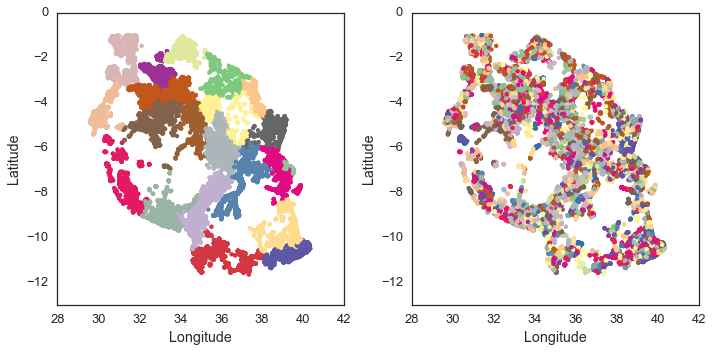

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(train_data['longitude'], train_data['latitude'], c=region_cmap, linewidth=0)
ax[0].set_ylim(-13, 0)
ax[0].set_xlim(28, 42)
ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')

ax[1].scatter(train_data['longitude'], train_data['latitude'], c=ward_cmap, linewidth=0)
ax[1].set_ylim(-13, 0)
ax[1].set_xlim(28, 42)
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')

plt.tight_layout()

In [33]:
dist_encoded = pumpitup.label_encode(train_data['district_code'], le)
dist_encoded_norm = dist_encoded / dist_encoded.max()
dist_cmap = [cmap(x) for x in dist_encoded_norm]

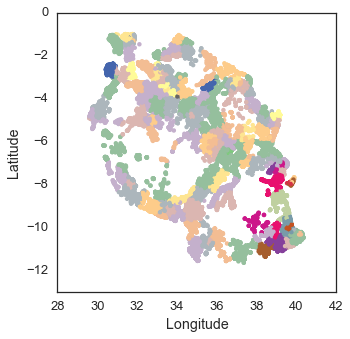

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(train_data['longitude'], train_data['latitude'], c=dist_cmap, linewidth=0)
ax.set_ylim(-13, 0)
ax.set_xlim(28, 42)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

The regions are shown clearly divided in the left figure. There are 21 regions, with each of them containing a significant number of points from the dataset. Using a colourmap to plot the wards does not make a lot of visual sense beyond simply highlighting the huge increase in precision. In some cases, there is only one point in a ward, making it too granular of a categorical feature for our purposes, so we will drop it.

We will also drop `district_code`, but for now I'm going to keep it as it will help to resolve some missing values issues later.

In [35]:
train_data.drop(['region_code', 'subvillage', 'ward'], axis=1, inplace=True)

The `lga` feature also contains geographic information more precise than region, but most likely not representing any other political boundaries. However, it does contain information about whether a point is rural or urban.

We can create a recoded feature from this that simply contains *rural*, *urban* and *other* as categories, adding this information on top of the regional information we already have.

In [36]:
series = train_data['lga'].copy()
series[series.str.contains('Rural')] = 'rural'
series[series.str.contains('Urban')] = 'urban'
other_flag = series.str.contains('rural') | series.str.contains('urban')
other_flag = other_flag == False
series[other_flag] = 'other'

train_data['lga'] = series

In [37]:
lga_cmap = train_data['lga'].copy()
lga_cmap[series.str.contains('rural')] = 'green'
lga_cmap[series.str.contains('urban')] = 'red'
other_flag = series.str.contains('rural') | series.str.contains('urban')
other_flag = other_flag == False
lga_cmap[other_flag] = 'blue'

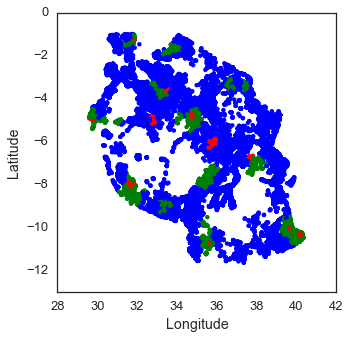

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(train_data['longitude'], train_data['latitude'], c=lga_cmap, linewidth=0)
ax.set_ylim(-13, 0)
ax.set_xlim(28, 42)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

Plotting our recoded `lga` feature on a map shows collections of points that look like urban centres. The distinction between *rural* and *other* is less clear.

There is also altitude and population information in the `gps_height` and `population` features. We can plot them in the same way to get an idea of how they're distributed. From the missing percentages, we can see that about 35% of both these features are zeros, so we can visualise where that is occuring too.

In [39]:
viridis = plt.cm.get_cmap('viridis')

In [40]:
gps_height_encoded = pumpitup.label_encode(train_data['gps_height'][train_data['gps_height'] > 0], le)
gps_height_encoded_norm = gps_height_encoded / gps_height_encoded.max()
gps_height_cmap = [viridis(x) for x in gps_height_encoded_norm]

population_encoded = pumpitup.label_encode(train_data['population'][train_data['population'] > 0], le)
population_encoded_norm = population_encoded / population_encoded.max()
population_cmap = [viridis(x) for x in population_encoded_norm]

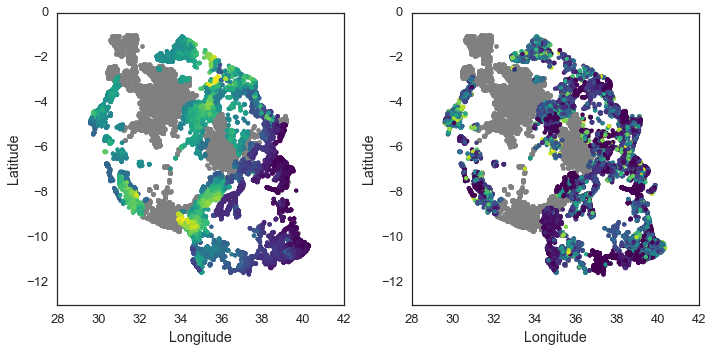

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(train_data['longitude'][train_data['gps_height'] == 0],\
           train_data['latitude'][train_data['gps_height'] == 0], color='gray')
ax[0].scatter(train_data['longitude'][train_data['gps_height'] > 0],\
           train_data['latitude'][train_data['gps_height'] > 0], c=gps_height_cmap, linewidth=0)
ax[0].set_ylim(-13, 0)
ax[0].set_xlim(28, 42)
ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')

ax[1].scatter(train_data['longitude'][train_data['population'] == 0],\
           train_data['latitude'][train_data['population'] == 0], color='gray')
ax[1].scatter(train_data['longitude'][train_data['population'] > 0],\
           train_data['latitude'][train_data['population'] > 0], c=population_cmap, linewidth=0)
ax[1].set_ylim(-13, 0)
ax[1].set_xlim(28, 42)
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')

plt.tight_layout()

In both the cases, the missing data is concentrated in particular regions, within clean boundaries. This might cause us some problems later for filling in missing values.

### Time

There are two features related to time; the `construction_year` and the `date_recorded`.

#### Construction Year

From our missing data percentages, we can see that `construction_year` is missing around 35% of the data which we should check out in more detail. I also wanted to see whether there was any trend of water pumps being installed in certain parts of the country at different times. Plotting the construction year against longitude and latitude we can see that to a first approximation, installations are distributed randomly through space and time. However we can see that the missing data is not random at all, and is concetrated in specific regions of the country. Again, this makes imputing the missing data intelligently quite difficult, as we have little to compare it to.

In [42]:
con_year_encoded = pumpitup.label_encode(train_data['construction_year'][train_data['construction_year'] > 0], le)
con_year_encoded_norm = con_year_encoded / con_year_encoded.max()
con_year_cmap = [viridis(x) for x in con_year_encoded_norm]

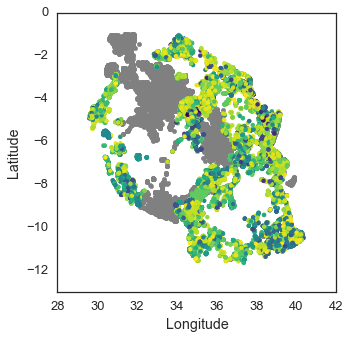

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(train_data['longitude'][train_data['construction_year'] == 0],\
           train_data['latitude'][train_data['construction_year'] == 0], color='gray')
ax.scatter(train_data['longitude'][train_data['construction_year'] > 0],\
           train_data['latitude'][train_data['construction_year'] > 0], c=con_year_cmap, linewidth=0)
ax.set_ylim(-13, 0)
ax.set_xlim(28, 42)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

Another way to look at this is to plot the longitude and latitude of each pump against the construction year in separate scatter plots. This gives us a sense of whether the installations have been concentrated in particular times and places. Besides years at the very beginning of the records and a few slightly more dense clusters, the distribution still seems to be fairly uniformly distributed.

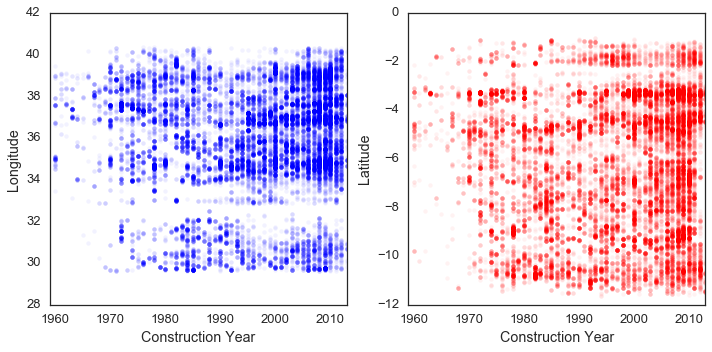

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(train_data['construction_year'][train_data['construction_year'] > 0],\
              train_data['longitude'][train_data['construction_year'] > 0], alpha=0.05, linewidth=0)
ax[0].set_xlim(1959, 2013)
ax[0].set_ylim(28, 42)
ax[0].set_ylabel('Longitude')
ax[0].set_xlabel('Construction Year')

ax[1].scatter(train_data['construction_year'][train_data['construction_year'] > 0],\
              train_data['latitude'][train_data['construction_year'] > 0], alpha=0.05, color='red', linewidth=0)
ax[1].set_xlim(1959, 2013)
ax[1].set_ylim(-12, 0)
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Construction Year')

plt.tight_layout()

One thing we could do is create a new feature by subtracting the `construction_year` from `date_recorded` to see whether the time in operation has any effect on failure rate. Before we do this however, I'd like to sort out the missing values, so we will leave `construction_year` alone for the time being.

#### Date Recorded

The `date_recorded` feature is a human readable date in a string format, which is not going to be very useful for our classifier. We can implement a helper function that turns the date into just the year and also derives a new feature `operation_years` which is the year of the record minus the year the pump was constructed.

There may also be a seasonal effect to pump failure (or at least the observance of pump failure). To take this into account, we create another feature that simply holds the month value from the feature.

In [45]:
train_data = pumpitup.convert_dates(train_data)

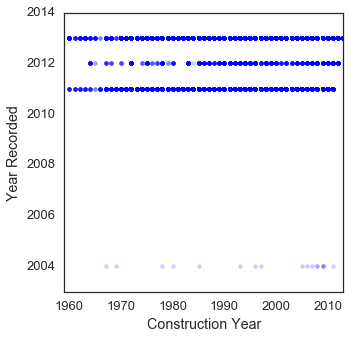

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(train_data['construction_year'], train_data['year_recorded'], alpha=0.2, linewidth=0)
ax.set_xlim(1959, 2013)
ax.set_ylim(2003, 2014)
ax.set_ylabel('Year Recorded')
ax.set_xlabel('Construction Year')

Looking at this scatter plot tells us that most of the tests were carried out during the period 2011 through 2013. There are a few points where the `year_recorded` is earlier than the `construction_year`. One other issue is that the missing `construction_year` data has led to records indicating that over a third of pumps have been in operation for around 2000 years. Good going. 

In [47]:
len(train_data[train_data['operation_years'] > 2000])

20709

### Other Variables

There are a few other variables that need to be picked and recategorised to clean up the data.

In particular `wpt_name`, `installer` and `funder` are features with a large number of unique variables.

According to the documentation, `wpt_name` refers to the name of the waterpoint. A few minutes spent looking at the entries and translating some Swahali into English gives us a bit more insight. In many cases the waterpoint name seems to be simply a name, but in others the name seems to refer to something of possible local significance that may affect how much a pump is used and how well it is maintained:

- Shuleni/Shule/School/Sekondari/Secondary/Msingi/Primary - School
- Zahanati/Clinic/Health - Health Clinic
- Hospitalini/Hospitali/Hospital - Hospital
- Office/Kijiji/Ofisini/Ofisi/Idara - Village Office
- Farm/Maziwa - Farm/Dairy
- Pump House/Bombani/Well/Kisima - Water related
- Kanisani/Kanisa/Church/Anglican/Pentecost/Luther/Msikitini/Msikitini/Mosque - Christian and Muslim places of worship
- Center/Market/Sokoni/Madukani - Town/Village Centre + Market/Shopping
- Ccm - Government?
- Kwa - Seems to accompany an individual's name

These groups seem to encompass a large enough number of points or have enough significance to form their own categories. There are lots of other smaller groups which we will group together.

In [85]:
train_data['wpt_name'] = train_data['wpt_name'].str.lower()
train_data['wpt_name'][train_data['wpt_name'].str.contains('school')] = 'school'
train_data['wpt_name'][train_data['wpt_name'].str.contains('shule')] = 'school'
train_data['wpt_name'][train_data['wpt_name'].str.contains('sekondari')] = 'school'
train_data['wpt_name'][train_data['wpt_name'].str.contains('secondary')] = 'school'
train_data['wpt_name'][train_data['wpt_name'].str.contains('sekondari')] = 'school'
train_data['wpt_name'][train_data['wpt_name'].str.contains('msingi')] = 'school'
train_data['wpt_name'][train_data['wpt_name'].str.contains('primary')] = 'school'

train_data['wpt_name'][train_data['wpt_name'].str.contains('clinic')] = 'health'
train_data['wpt_name'][train_data['wpt_name'].str.contains('zahanati')] = 'health'
train_data['wpt_name'][train_data['wpt_name'].str.contains('health')] = 'health'
train_data['wpt_name'][train_data['wpt_name'].str.contains('hospital')] = 'health'

train_data['wpt_name'][train_data['wpt_name'].str.contains('ccm')] = 'official'
train_data['wpt_name'][train_data['wpt_name'].str.contains('office')] = 'official'
train_data['wpt_name'][train_data['wpt_name'].str.contains('kijiji')] = 'official'
train_data['wpt_name'][train_data['wpt_name'].str.contains('ofis')] = 'official'
train_data['wpt_name'][train_data['wpt_name'].str.contains('idara')] = 'official'

train_data['wpt_name'][train_data['wpt_name'].str.contains('farm')] = 'farm'
train_data['wpt_name'][train_data['wpt_name'].str.contains('maziwa')] = 'farm'

train_data['wpt_name'][train_data['wpt_name'].str.contains('pump house')] = 'water'
train_data['wpt_name'][train_data['wpt_name'].str.contains('pump')] = 'water'
train_data['wpt_name'][train_data['wpt_name'].str.contains('bombani')] = 'water'
train_data['wpt_name'][train_data['wpt_name'].str.contains('maji')] = 'water'
train_data['wpt_name'][train_data['wpt_name'].str.contains('water')] = 'water'

train_data['wpt_name'][train_data['wpt_name'].str.contains('kanisani')] = 'religious'
train_data['wpt_name'][train_data['wpt_name'].str.contains('kanisa')] = 'religious'
train_data['wpt_name'][train_data['wpt_name'].str.contains('church')] = 'religious'
train_data['wpt_name'][train_data['wpt_name'].str.contains('luther')] = 'religious'
train_data['wpt_name'][train_data['wpt_name'].str.contains('anglican')] = 'religious'
train_data['wpt_name'][train_data['wpt_name'].str.contains('pentecost')] = 'religious'
train_data['wpt_name'][train_data['wpt_name'].str.contains('msikitini')] = 'religious'
train_data['wpt_name'][train_data['wpt_name'].str.contains('msikiti')] = 'religious'

train_data['wpt_name'][train_data['wpt_name'].str.contains('center')] = 'center'
train_data['wpt_name'][train_data['wpt_name'].str.contains('market')] = 'center'
train_data['wpt_name'][train_data['wpt_name'].str.contains('sokoni')] = 'center'
train_data['wpt_name'][train_data['wpt_name'].str.contains('madukani')] = 'center'

train_data['wpt_name'][train_data['wpt_name'].str.contains('kwa')] = 'name'

#finally change any values with less than 500 records to 'other' as well as the 'none' values
value_counts = train_data['wpt_name'].value_counts()
to_remove = value_counts[value_counts <= 500].index
train_data['wpt_name'].replace(to_remove, 'other', inplace=True)

train_data['wpt_name'][train_data['wpt_name'].str.contains('none')] = 'other'

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/

In [101]:
train_data['wpt_name'].value_counts()

other        26665
name         23326
school        5599
religious     1369
health        1204
official       702
center         535
Name: wpt_name, dtype: int64

We're left with some categories of unknown meaning but hopefully they are of some significance.

Next we can look at `funder` and `installer`. Both of these have some large categories and lots of small ones.

For `funder` the large categories seem to be either governments or large NGOs while the small ones are unknown entities. We can keep the big ones, and group the rest under _other_.

In [50]:
value_counts = train_data['funder'].value_counts()
to_remove = value_counts[value_counts <= 500].index
train_data['funder'].replace(to_remove, 'other', inplace=True)

In [51]:
train_data['funder'].value_counts()

other                     26939
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
Kkkt                       1287
World Vision               1246
Unicef                     1057
Tasaf                       877
District Council            843
Dhv                         829
Private Individual          826
Dwsp                        811
0                           777
Norad                       765
Germany Republi             610
Tcrs                        602
Ministry Of Water           590
Water                       583
Name: funder, dtype: int64

In [113]:
0.0084*len(train_data)

498.96

For `installer`, we can do the same.

In [52]:
value_counts = train_data['installer'].value_counts()
to_remove = value_counts[value_counts <= 500].index
train_data['installer'].replace(to_remove, 'other', inplace=True)

In [53]:
train_data['installer'].value_counts()

other                 26553
DWE                   17402
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
CES                     610
Community               553
DANID                   552
District Council        551
HESAWA                  539
Name: installer, dtype: int64

Good, it now looks like we're ready to deal with the missing data, before finally making some predictions.

## Missing Data

Let's check our missing percentages again after all that work. 

In [54]:
pumpitup.percent_missing(train_data)

amount_tsh 70.099327 0
funder 6.119529 NaN
gps_height 34.407407 0
installer 6.153199 NaN
longitude 3.050505 0
latitude 3.050505 0
district_code 0.038721 0
population 35.994949 0
public_meeting 5.612795 NaN
permit 5.144781 NaN
construction_year 34.863636 0
year_recorded 0.000000 0
month_recorded 0.000000 0
operation_years 0.989899 0


[]

We can see that there is still quite a bit of work to do. Firstly we can get rid of `amount_tsh` which represents the amount of water available to a pump. This could be useful, but there's just too much missing.

In [55]:
train_data.drop('amount_tsh', axis=1, inplace=True)

In [56]:
train_data.head(1)

,funder,gps_height,installer,longitude,latitude,wpt_name,basin,region,district_code,lga,population,public_meeting,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,year_recorded,month_recorded,operation_years
0,other,1390,other,34.938093,-9.856322,other,Lake Nyasa,Iringa,5,other,109,True,False,1999,gravity,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,2011,3,12


### Geographic

#### Longitude and Latitude

Next let's go back to our longitude and latitude. We have a small percentage of these missing, but we have some pretty granular geographic data in the form of the `district_code` within `regions`. We can find the mean longitude and latitude within each district code and then use these to fill in any missing longitude and latitude data.

In [57]:
mask1 = pumpitup.flag_missing_s(train_data['longitude'])
train_data['longitude'][mask1] = np.nan
train_data.loc[mask1, 'longitude'] = train_data.groupby(['region', 'district_code']).transform('mean')
mask2 = train_data['longitude'].isnull()
train_data.loc[mask2, 'longitude'] = train_data.groupby(['region']).transform('mean')

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [58]:
mask3 = pumpitup.flag_missing_s(train_data['latitude'])
train_data['latitude'][mask3] = np.nan
train_data.loc[mask3, 'latitude'] = train_data.groupby(['region', 'district_code']).transform('mean')
mask4 = train_data['latitude'].isnull()
train_data.loc[mask4, 'latitude'] = train_data.groupby(['region']).transform('mean')

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


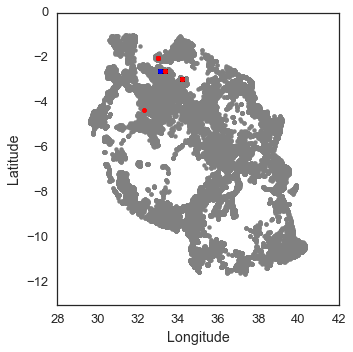

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(train_data['longitude'], train_data['latitude'], color='gray', linewidth=0)
ax.scatter(train_data['longitude'][mask1], train_data['latitude'][mask1], color='red', linewidth=0)
ax.scatter(train_data['longitude'][mask2], train_data['latitude'][mask2], color='blue', linewidth=0)
ax.set_ylim(-13, 0)
ax.set_xlim(28, 42)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plt.tight_layout()

The red dots show the locations of points where latitude and longitude were imputed using `region` and `district_code`, while the blue does show the locations of points where latitude and longitude were imputed using `region` only

**GPS Height**

From the previous map of the altitude of each pump, we can see a trend of lower altitudes closer to the coast, with elevation increasing further inland. It's difficult to imput the missing `gps_height` values precisely, but we can try to resample the map and use some mean values.

In [60]:
df_encoded = train_data[['latitude', 'longitude']]

In [61]:
series = backup.gps_height

In [62]:
height_filled = pumpitup.fill_missing_knn(series, df_encoded, k=5)

/Users/George/projects/unv/pumpit/scripts/pumpitup.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  series[series_missing_flags] = missing_means


In [63]:
train_data['gps_height'] = height_filled

In [64]:
gpsf_height_encoded_norm = height_filled / height_filled.max()
gpsf_height_cmap = [viridis(x) for x in gpsf_height_encoded_norm]

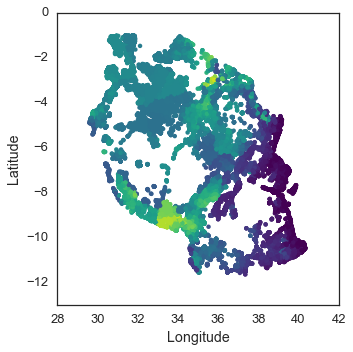

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(train_data['longitude'], train_data['latitude'], c=gpsf_height_cmap, linewidth=0)
ax.set_ylim(-13, 0)
ax.set_xlim(28, 42)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plt.tight_layout()

That looks pretty reasonable! It's certainly going to be better than simply picking the mean or median. In fact, it basically is picking the mean, but locally to where each point is located.

**Population**

About 35% of the population data is missing. Population will vary with geographical features such as land type and governmental boundaries. To impute the missing values, we're going to use the `lga`, `region` and `district_code` features. We can use a similar method to that used to impute the missing longitude and latitude values.

In [66]:
mask1 = pumpitup.flag_missing_s(train_data['population'])
train_data['population'][mask1] = np.nan
train_data.loc[mask1, 'population'] = train_data.groupby(['lga', 'region','district_code']).transform('mean')
mask2 = train_data['population'].isnull()
train_data.loc[mask2, 'population'] = train_data.groupby(['lga', 'region']).transform('mean')
mask3 = train_data['population'].isnull()
train_data.loc[mask3, 'population'] = train_data.groupby('lga').transform('mean')

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [67]:
train_data['population'] = train_data['population'].astype(int)

In [68]:
population_encoded = pumpitup.label_encode(train_data['population'][train_data['population'] > 0], le)
population_encoded_norm = population_encoded / population_encoded.max()
population_cmap = [viridis(x) for x in population_encoded_norm]

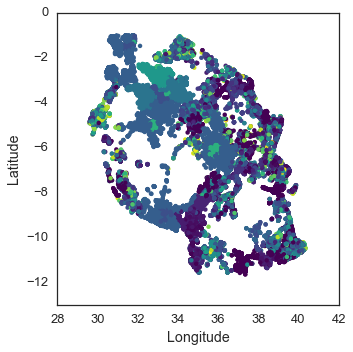

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(train_data['longitude'][train_data['population'] == 0],\
           train_data['latitude'][train_data['population'] == 0], color='gray')
ax.scatter(train_data['longitude'][train_data['population'] > 0],\
           train_data['latitude'][train_data['population'] > 0], c=population_cmap, linewidth=0)
ax.set_ylim(-13, 0)
ax.set_xlim(28, 42)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plt.tight_layout()

We can see that urban areas have higher populations, while rural and others seem to have lower populations, with the data varying across regions and districts. The imputed values don't seem to fall quite as low as those found in some parts of the map with data available.

### Time

We have some missing values for the `construction_year` feature, or at least, it is unlikely that water pumps installed in the year 0 are still in use today.

We looked before at whether there was a strong relationship between the construction year of a pump and the location, but that didn't seem to be too strong. Maybe we can infer some information from the type of pump, who installed it.

Just before we do that, we also saw that some of the record dates fell during years that were before the construction years. This can't be right. I'm simply going to replace any where `year_recorded` < `construction_year` with the median year recorded.

In [70]:
train_data['year_recorded'][train_data['year_recorded'] < train_data['operation_years']] = train_data['year_recorded'].median()

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [71]:
mask1 = pumpitup.flag_missing_s(train_data['construction_year'])
train_data['construction_year'][mask1] = np.nan
train_data.loc[mask1, 'construction_year'] = train_data.groupby(['extraction_type', 'installer']).transform('median')
mask2 = train_data['construction_year'].isnull()
train_data.loc[mask2, 'construction_year'] = train_data.groupby(['extraction_type']).transform('median')

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [72]:
train_data['construction_year'] = train_data['construction_year'].astype(int)

We can now calculate the number of years in operation and replace any negative years with the median date.

In [73]:
train_data['operation_years'] = (train_data['year_recorded'] - train_data['construction_year']).astype(int)

In [74]:
train_data['operation_years'][train_data['operation_years'] < 0] = train_data['operation_years'].median()

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Categorical Features

#### Installer and Funder

First up, let's look at the `installer` and `funder` features again. If we plot them on a map, we can see that there is some degree of geographical clustering.

In [75]:
installer = train_data['installer']
installer[pd.isnull(installer)] = 'none'
funder = train_data['funder']
funder[pd.isnull(funder)] = 'none'

isntaller_encoded = pumpitup.label_encode(installer, le)
installer_encoded_norm = isntaller_encoded / isntaller_encoded.max()
isntaller_cmap = [cmap(x) for x in installer_encoded_norm]

funder_encoded = pumpitup.label_encode(funder, le)
funder_encoded_norm = funder_encoded / funder_encoded.max()
funder_cmap = [cmap(x) for x in funder_encoded_norm]

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


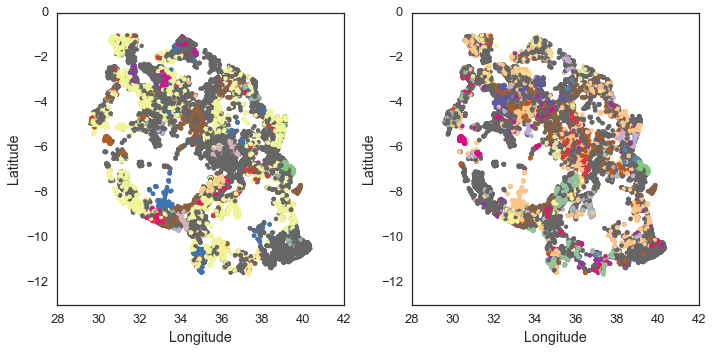

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(train_data['longitude'], train_data['latitude'], c=isntaller_cmap, linewidth=0)
ax[0].set_ylim(-13, 0)
ax[0].set_xlim(28, 42)
ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')

ax[1].scatter(train_data['longitude'], train_data['latitude'], c=funder_cmap, linewidth=0)
ax[1].set_ylim(-13, 0)
ax[1].set_xlim(28, 42)
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')

plt.tight_layout()

To impute these, we will again use imputation by grouping with region and district code. Any missing values in region and district code combinations that do not have any other values will simply be relabeled as *other*.

In [77]:
mask = train_data['installer'].isnull()
train_data['installer'][mask] = 'other'
train_data.loc[mask, 'installer'] = train_data.groupby(['region', 'district_code'])['installer'].transform(lambda x: x.value_counts().index[0])


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


And now `installer`.

In [78]:
mask = train_data['funder'].isnull()
train_data['funder'][mask] = 'other'
train_data.loc[mask, 'funder'] = train_data.groupby(['region', 'district_code'])['funder'].transform(lambda x: x.value_counts().index[0])

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


#### Permit and Public Meeting

Both of these features are boolean. A quick look at grouping by `region` and `district_code` shows that different places have different distributions of *True* vs *False*. Without much else to go on at this point, we can use these to fill in the missing values, defaulting to *True* (the more common overall in both features) if there is only missing values in the district.

In [79]:
mask = train_data['permit'].isnull()
train_data['permit'][mask] = True
train_data.loc[mask, 'permit'] = train_data.groupby(['region', 'district_code'])['permit'].transform(lambda x: x.value_counts().index[0])

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [80]:
mask = train_data['public_meeting'].isnull()
train_data['public_meeting'][mask] = True
train_data.loc[mask, 'public_meeting'] = train_data.groupby(['region', 'district_code'])['public_meeting'].transform(lambda x: x.value_counts().index[0])

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Data cleaning done!

We can now finally drop `district_code` from our dataframe.

In [81]:
train_data.drop('district_code', axis=1, inplace=True)

# Test Data Cleaning

The problem is that the test data is smaller than the training data. We need to make sure that despite this, we end up with the same categorical features and encoding rules for both datasets, otherwise our prediction model is not going to be so great.

At the end of all this, we have a full process for cleaning up our data. This is captured in the function named `cleanitup`, shown below just for convenience.

In [ ]:
def cleanitup(df):
    
    min_cat_size = 0.008 * len(df)
    
    df.drop(['id', 'recorded_by', 'num_private'], axis=1, inplace=True)
    
    # EXTRACTION TYPES
    # rename some categories in the finest featureset
    # drop mid level information in feature extraction_type_group
    df['extraction_type'].replace('other - swn 81', 'swn 81', inplace=True)
    df['extraction_type'].replace('other - mkulima/shinyanga', 'other handpump', inplace=True)
    df['extraction_type'].replace('other - play pump', 'other handpump', inplace=True)
    df['extraction_type'].replace('cemo', 'other motorpump', inplace=True)
    df['extraction_type'].replace('climax', 'other motorpump', inplace=True)
    df.drop('extraction_type_group', axis=1, inplace=True)
    
    # MANAGEMENT
    # do nothing
    
    # SCHEME
    # drop scheme_name as too many categories and missing values
    # also drop scheme_management as basically the same as management
    df.drop('scheme_name', axis=1, inplace=True)
    df.drop('scheme_management', axis=1, inplace=True)
    
    # PAYMENT
    # two identical features - drop payment
    df.drop('payment', axis=1, inplace=True)
    
    # WATER QUALITY
    # water_quality contains slightly more information than quality_group
    df.drop('quality_group', axis=1, inplace=True)
    
    # QUANTITY
    # two identical groups - drop quantity_group
    df.drop('quantity_group', axis=1, inplace=True)
    
    #SOURCE
    # drop mid level source_type
    df.drop('source_type', axis=1, inplace=True)
    df['source'].replace('other', 'unknown', inplace=True)
    
    # WATERPOINT
    # drop waterpoint_type_group as less precise than waterpoint_type
    df.drop('waterpoint_type_group', axis=1, inplace=True)
    
    # GEOGRAPHICAL
    # drop mid level geographic information
    # keep district_code as this comes in useful later!
    df.drop(['region_code', 'subvillage', 'ward'], axis=1, inplace=True)
    
    lga = df['lga'].copy()
    lga[lga.str.contains('Rural')] = 'rural'
    lga[lga.str.contains('Urban')] = 'urban'
    other_flag = lga.str.contains('rural') | lga.str.contains('urban')
    other_flag = other_flag == False
    lga[other_flag] = 'other'
    df['lga'] = lga
    
    # TIME
    # convert date_recorded to days since epoch and year month
    df = pumpitup.convert_dates(df)
    
    # WATERPOINT NAME
    df['wpt_name'] = df['wpt_name'].str.lower()
    df['wpt_name'][df['wpt_name'].str.contains('school')] = 'school'
    df['wpt_name'][df['wpt_name'].str.contains('shule')] = 'school'
    df['wpt_name'][df['wpt_name'].str.contains('sekondari')] = 'school'
    df['wpt_name'][df['wpt_name'].str.contains('secondary')] = 'school'
    df['wpt_name'][df['wpt_name'].str.contains('sekondari')] = 'school'
    df['wpt_name'][df['wpt_name'].str.contains('msingi')] = 'school'
    df['wpt_name'][df['wpt_name'].str.contains('primary')] = 'school'

    df['wpt_name'][df['wpt_name'].str.contains('clinic')] = 'health'
    df['wpt_name'][df['wpt_name'].str.contains('zahanati')] = 'health'
    df['wpt_name'][df['wpt_name'].str.contains('health')] = 'health'
    df['wpt_name'][df['wpt_name'].str.contains('hospital')] = 'health'

    df['wpt_name'][df['wpt_name'].str.contains('ccm')] = 'official'
    df['wpt_name'][df['wpt_name'].str.contains('office')] = 'official'
    df['wpt_name'][df['wpt_name'].str.contains('kijiji')] = 'official'
    df['wpt_name'][df['wpt_name'].str.contains('ofis')] = 'official'

    df['wpt_name'][df['wpt_name'].str.contains('farm')] = 'farm'
    df['wpt_name'][df['wpt_name'].str.contains('maziwa')] = 'farm'

    df['wpt_name'][df['wpt_name'].str.contains('pump house')] = 'pump'

    df['wpt_name'][df['wpt_name'].str.contains('kanisani')] = 'church'
    df['wpt_name'][df['wpt_name'].str.contains('church')] = 'church'
    df['wpt_name'][df['wpt_name'].str.contains('luther')] = 'church'
    df['wpt_name'][df['wpt_name'].str.contains('anglican')] = 'church'
    df['wpt_name'][df['wpt_name'].str.contains('pentecost')] = 'church'

    df['wpt_name'][df['wpt_name'].str.contains('center')] = 'center'
    df['wpt_name'][df['wpt_name'].str.contains('market')] = 'center'

    df['wpt_name'][df['wpt_name'].str.contains('kwa')] = 'name'

    #finally change any values with less than 500 records to 'other' as well as the 'none' values
    value_counts = df['wpt_name'].value_counts()
    to_remove = value_counts[value_counts <= 0.0016 * len(df)].index
    df['wpt_name'].replace(to_remove, 'other', inplace=True)

    df['wpt_name'][df['wpt_name'].str.contains('none')] = 'other'
    
    # INSTALLER AND FUNDER
    value_counts = train_data['funder'].value_counts()
    to_remove = value_counts[value_counts <= min_cat_size].index
    train_data['funder'].replace(to_remove, 'other', inplace=True)
    value_counts = train_data['installer'].value_counts()
    to_remove = value_counts[value_counts <= min_cat_size].index
    train_data['installer'].replace(to_remove, 'other', inplace=True)
    
    ### MISSING DATA ###
    df.drop('amount_tsh', axis=1, inplace=True)
    
    # LONG - LAT
    # Use region and district_codes to fill in missing longitude and latitude data
    mask1 = pumpitup.flag_missing_s(df['longitude'])
    df['longitude'][mask1] = np.nan
    df.loc[mask1, 'longitude'] = df.groupby(['region', 'district_code']).transform('mean')
    mask2 = df['longitude'].isnull()
    df.loc[mask2, 'longitude'] = df.groupby(['region']).transform('mean')
    
    mask3 = pumpitup.flag_missing_s(df['latitude'])
    df['latitude'][mask3] = np.nan
    df.loc[mask3, 'latitude'] = df.groupby(['region', 'district_code']).transform('mean')
    mask4 = df['latitude'].isnull()
    df.loc[mask4, 'latitude'] = df.groupby(['region']).transform('mean')
    
    # GPS HEIGHT
    # Use KNN imputation of the longitude and latitude variables
    df_encoded = df[['latitude', 'longitude']]
    series = df.gps_height
    height_filled = pumpitup.fill_missing_knn(series, df_encoded, k=5)
    df['gps_height'] = height_filled
    
    # POPULATION
    # use grouping of geographical area, region and district code to impute missing population data
    mask1 = pumpitup.flag_missing_s(df['population'])
    df['population'][mask1] = np.nan
    df.loc[mask1, 'population'] = df.groupby(['lga', 'region','district_code']).transform('mean')
    mask2 = df['population'].isnull()
    df.loc[mask2, 'population'] = df.groupby(['lga', 'region']).transform('mean')
    mask3 = df['population'].isnull()
    df.loc[mask3, 'population'] = df.groupby('lga').transform('mean')
    
    train_data['population'] = train_data['population'].astype(int)
    
    # TIME
    df['year_recorded'][df['year_recorded'] < df['operation_years']] = df['year_recorded'].median()
    
    mask1 = pumpitup.flag_missing_s(df['construction_year'])
    df['construction_year'][mask1] = np.nan
    df.loc[mask1, 'construction_year'] = df.groupby(['extraction_type', 'installer']).transform('median')
    mask2 = df['construction_year'].isnull()
    df.loc[mask2, 'construction_year'] = df.groupby(['extraction_type']).transform('median')
    mask3 = df['construction_year'].isnull()
    df['construction_year'][mask3] = df['construction_year'].median()
    
    df['construction_year'] = df['construction_year'].astype(int)
    
    df['operation_years'] = (df['year_recorded'] - df['construction_year']).astype(int)
    df['operation_years'][df['operation_years'] < 0] = df['operation_years'].median()
    
    # INSTALLER AND FUNDER
    mask = df['installer'].isnull()
    df['installer'][mask] = 'other'
    df.loc[mask, 'installer'] = df.groupby(['region', 'district_code'])['installer']\
        .transform(lambda x: x.value_counts().index[0])
    mask = df['funder'].isnull()
    df['funder'][mask] = 'other'
    df.loc[mask, 'funder'] = df.groupby(['region', 'district_code'])['funder']\
        .transform(lambda x: x.value_counts().index[0])
        
    # PERMIT AND PUBLIC MEETING
    mask = df['permit'].isnull()
    df['permit'][mask] = True
    df.loc[mask, 'permit'] = df.groupby(['region', 'district_code'])['permit'].transform(lambda x: x.value_counts().index[0])

    mask = df['public_meeting'].isnull()
    df['public_meeting'][mask] = True
    df.loc[mask, 'public_meeting'] = df.groupby(['region', 'district_code'])['public_meeting'].transform(lambda x: x.value_counts().index[0])
    
    df.drop('district_code', axis=1, inplace=True)
    
    return df